In [ ]:
import os, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

IMG_PATH = "train"  
CSV_PATH = "train.csv"
BATCH_SIZE = 8
EPOCHS = 15       
LR = 1e-3         
Random_Seed = 42  

In [14]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_PATH, transform=transform)

generator = torch.Generator().manual_seed(Random_Seed)  
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # residual/skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity    # <--- inti residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stages: [3,4,6,3] untuk ResNet-34
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # jika dimensi berubah (stride!=1 atau channel berubah), siapkan downsample
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet34(num_classes=5):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

model = resnet34(num_classes=5).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [ ]:
def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
    loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return loss, acc

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(EPOCHS):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss {tr_loss:.4f} | Val Loss {va_loss:.4f} | "
          f"Train Acc {tr_acc:.2f}% | Val Acc {va_acc:.2f}%")

d:\Alat program\SupportSystem\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/15 | Train Loss 1.5514 | Val Loss 1.4679 | Train Acc 34.76% | Val Acc 36.04%


OSError: broken data stream when reading image file

In [ ]:
torch.save(model.state_dict(), "resnet34_food5.pth")
np.savez("resnet34_history.npz",
         train_loss=np.array(history["train_loss"]),
         val_loss=np.array(history["val_loss"]),
         train_acc=np.array(history["train_acc"]),
         val_acc=np.array(history["val_acc"]),
         meta=np.array([json.dumps({
             "batch_size": BATCH_SIZE,
             "epochs": EPOCHS,
             "lr": LR,
             "optimizer": "adam",
             "split":"80/20",
             "seed": Random_Seed
         })], dtype=object))
print("Saved: resnet34_food5.pth & resnet34_history.npz")

Saved: resnet34_food5.pth & resnet34_history.npz


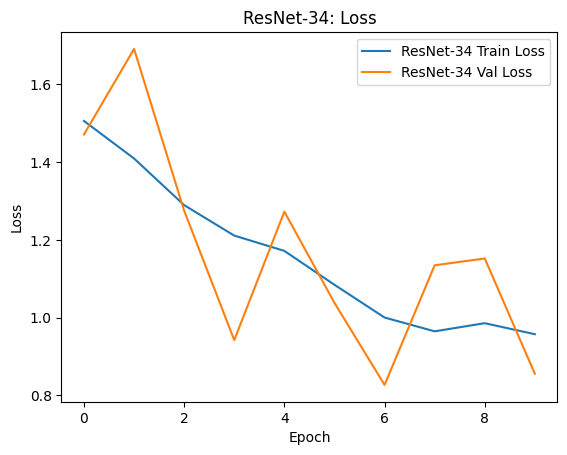

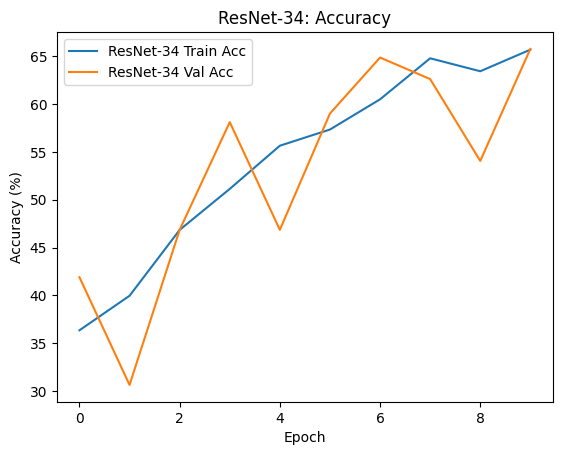


[Info] plain34_history.npz tidak ditemukan. Lewati perbandingan otomatis. Pastikan file baseline dari Tahap 1 disimpan dengan nama yang sama agar bisa dibandingkan langsung.


In [ ]:
def plot_history(h, label_prefix):
    plt.figure()
    plt.plot(h["train_loss"], label=f"{label_prefix} Train Loss")
    plt.plot(h["val_loss"],   label=f"{label_prefix} Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{label_prefix}: Loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(h["train_acc"], label=f"{label_prefix} Train Acc")
    plt.plot(h["val_acc"],   label=f"{label_prefix} Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title(f"{label_prefix}: Accuracy"); plt.legend(); plt.show()

# Plot ResNet-34
plot_history(history, "ResNet-34")

# Coba load baseline (Plain-34) jika ada
if os.path.exists("plain34_history.npz"):
    base = np.load("plain34_history.npz", allow_pickle=True)
    base_hist = {
        "train_loss": base["train_loss"].tolist(),
        "val_loss":   base["val_loss"].tolist(),
        "train_acc":  base["train_acc"].tolist(),
        "val_acc":    base["val_acc"].tolist()
    }
    plot_history(base_hist, "Plain-34")
    
    # Plot comparison overlay (Val curves)
    plt.figure()
    plt.plot(base_hist["val_loss"], label="Plain-34 Val Loss")
    plt.plot(history["val_loss"],   label="ResNet-34 Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Val Loss Comparison"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(base_hist["val_acc"], label="Plain-34 Val Acc")
    plt.plot(history["val_acc"],   label="ResNet-34 Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Val Acc Comparison"); plt.legend(); plt.show()
    
    # Tabel ringkas (epoch terakhir)
    last = {
        "Model":        ["Plain-34", "ResNet-34"],
        "Train Loss":   [base_hist["train_loss"][-1], history["train_loss"][-1]],
        "Val Loss":     [base_hist["val_loss"][-1],   history["val_loss"][-1]],
        "Train Acc %":  [base_hist["train_acc"][-1],  history["train_acc"][-1]],
        "Val Acc %":    [base_hist["val_acc"][-1],    history["val_acc"][-1]],
    }
    df = pd.DataFrame(last)
    print("\nPerbandingan (epoch terakhir):")
    print(df.to_string(index=False))
else:
    print("\n[Info] plain34_history.npz tidak ditemukan. "
          "Lewati perbandingan otomatis. Pastikan file baseline dari Tahap 1 disimpan "
          "dengan nama yang sama agar bisa dibandingkan langsung.")